# I scraped some data, now let's use it
Scraping_Redfin_lab_notebook.ipynb runs through the process of figuring out what on earth I was doing and scraping; {potential future .py file may contain just the necessary lists and code}.

The big idea is this: there's a lot of art and even more nebulous "gut feeling" as to what price a house should be listed at. A list price that's too low runs the risk of limiting the price you get because of the anchoring effect (where the number first named skews peoples' perception of what a value should be); even if there is a bidding war with escalation clauses, the limit may be skewed by the initial listing price. A listing price that's too high seems likely to lead to a house being on the market longer, and it may discourage buyers enough that you end up with just one offer, not multiples with escalation clauses which maximize the price the eventual buyer pays for the house.

I'm trying to build a model which will take in a variety of features about a house (size, bedrooms and bathrooms, location, lot size, type of dwelling, age, etc.) and spit out a best guess for the "correct" listing price according to the market.

The purpose of this notebook is to take data scraped from Redfin, clean it, visualize it, engineer and scale the data as appropriate, and get it ready to feed into a model.

In [3]:
import pickle
# Let's unpickle this thing!
with open("listingpage_scrapes.txt", "rb") as fp:
    listing_data = pickle.load(fp)


In [104]:
import pickle
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import re
import datetime as dt

In [7]:
listings = pd.DataFrame(listing_data)
listings.head()

,address,ZIP,comm,price,beds,baths,size,style,lot,age,status,sold,park,brok,url
0,10024 63rd Ave S,98178,Upper Rainier Beach,760000,4.0,2.75,2670,"2 Stories with Basement, Tudor",6232,1921,Sold,"MAR 30, 2020",Off-Street Parking,3.0,https://www.redfin.com/WA/Seattle/1723-S-Fores...
1,10024 63rd Ave S,98178,Upper Rainier Beach,760000,4.0,2.75,2670,"2 Stories with Basement, Tudor",6232,1921,Sold,"MAR 30, 2020",Off-Street Parking,3.0,https://www.redfin.com/WA/Seattle/3610-1st-Ave...
2,10024 63rd Ave S,98178,Upper Rainier Beach,760000,4.0,2.75,2670,"2 Stories with Basement, Tudor",6232,1921,Sold,"MAR 30, 2020",Off-Street Parking,3.0,https://www.redfin.com/WA/Seattle/3052-23rd-Av...
3,10024 63rd Ave S,98178,Upper Rainier Beach,760000,4.0,2.75,2670,"2 Stories with Basement, Tudor",6232,1921,Sold,"MAR 30, 2020",Off-Street Parking,3.0,https://www.redfin.com/WA/Seattle/924-N-87th-S...
4,10024 63rd Ave S,98178,Upper Rainier Beach,760000,4.0,2.75,2670,"2 Stories with Basement, Tudor",6232,1921,Sold,"MAR 30, 2020",Off-Street Parking,3.0,https://www.redfin.com/WA/Seattle/8706-Phinney...


In [8]:
listings.describe()

,price,beds,baths,size,lot,age,brok
count,3111.0,3111.0,3111.00,3111.0,3111.0,3111.0,3111.0
mean,760000.0,4.0,2.75,2670.0,6232.0,1921.0,3.0
std,0.0,0.0,0.00,0.0,0.0,0.0,0.0
min,760000.0,4.0,2.75,2670.0,6232.0,1921.0,3.0
25%,760000.0,4.0,2.75,2670.0,6232.0,1921.0,3.0
50%,760000.0,4.0,2.75,2670.0,6232.0,1921.0,3.0
75%,760000.0,4.0,2.75,2670.0,6232.0,1921.0,3.0
max,760000.0,4.0,2.75,2670.0,6232.0,1921.0,3.0


ENTIRE dataset is the same listing (the listing I was using to test the scraper and set response = that thing).

Holy Hannah that's a hell of a mistake.

In [9]:
with open('test_it5.txt', 'rb') as fp:
    test_scrapes = pickle.load(fp)

In [6]:
from bs4 import BeautifulSoup

In [14]:
listing_scrapes = []
dumps_list = ['listingpage_scrapes_dump100', 'listingpage_scrapes_dump200', 
              'listingpage_scrapes_dump300', 'listingpage_scrapes_dump400', 'listingpage_scrapes_dump500', 
              'listingpage_scrapes_dump600', 'listingpage_scrapes_dump700', 'listingpage_scrapes_dump800', 
              'listingpage_scrapes_dump900', 'listingpage_scrapes_dump1000', 'listingpage_scrapes_dump1100', 
              'listingpage_scrapes_dump1200', 'listingpage_scrapes_dump1300', 'listingpage_scrapes_dump1400', 
              'listingpage_scrapes_dump1500', 'listingpage_scrapes_dump1600', 'listingpage_scrapes_dump1700', 
              'listingpage_scrapes_dump1800', 'listingpage_scrapes_dump1900', 'listingpage_scrapes_dump2000', 
              'listingpage_scrapes_dump2100', 'listingpage_scrapes_dump2200', 'listingpage_scrapes_dump2300', 
              'listingpage_scrapes_dump2400', 'listingpage_scrapes_dump2500', 'listingpage_scrapes_dump2600', 
              'listingpage_scrapes_dump2700', 'listingpage_scrapes_dump2800', 'listingpage_scrapes_dump2900', 
              'listingpage_scrapes_dump3112']
for i in dumps_list:
    with open((i+'.txt'), 'rb') as fp:
        listing_scrapes += pickle.load(fp)

In [15]:
len(listing_scrapes)

6218

In [16]:
for i in range(0, len(listing_scrapes), 2):
    listing_scrapes[i] = BeautifulSoup(listing_scrapes[i], 'html.parser')

In [30]:
def parseSoldPage(soup, url):
    """
    Grabs desired information from Redfin page for a single sold property using BeatifulSoup.
    Returns a dictionary of the desired information.
    """
    pull_digits = re.compile('[0-9.]+')
    property_dict = {}
    try:
        property_dict['address'] = soup.find('span', class_ = 'street-address').text
    except:
        property_dict['address'] = ''
    try:
        property_dict['ZIP'] = soup.find('span', class_ = 'postal-code').text
    except:
        property_dict['ZIP'] = ''
    try:
        property_dict['comm'] = soup.find(string = 'Community').find_next('span', class_ = 'content text-right').text
    except:
        property_dict['comm'] = ''
    try:
        property_dict['price'] = pull_digits.search(soup.find('div', class_ = 'info-block price').text.replace(',', '')).group()
    except:
        property_dict['price'] = ''
    try:
        property_dict['beds'] = pull_digits.search(soup.find(attrs = {'data-rf-test-id': "abp-beds"}).find('div', class_ = 'statsValue').text).group()
    except:
        property_dict['beds'] = ''
    try:
        property_dict['baths'] = pull_digits.search(soup.find(attrs = {'data-rf-test-id': "abp-baths"}).find('div', class_ = 'statsValue').text).group()
    except:
        property_dict['baths'] = ''
    try:
        property_dict['size'] = pull_digits.search(soup.find('div', class_ = 'info-block sqft').find('span', class_ = 'statsValue').text.replace(',', '')).group()
    except:
        property_dict['size'] = ''
    try:
        property_dict['style'] = soup.find(string = 'Style').find_next().text
    except:
        property_dict['style'] = ''
    try:
        property_dict['lot'] = pull_digits.search(soup.find(string = 'Lot Size').find_next().text.replace(',', '')).group()
    except:
        property_dict['lot'] = ''
    try:
        property_dict['age'] = soup.find(string = 'Year Built').find_next().text
    except:
        property_dict['age'] = ''
    try:
        property_dict['status'] = soup.find(attrs = {'data-rf-test-id': 'abp-status'}).find('span', class_ = 'value').text
    except:
        property_dict['status'] = ''
    try:
        property_dict['sold'] = soup.find('div', class_ = "Pill Pill--red padding-vert-smallest padding-horiz-smaller font-size-smaller font-weight-bold font-color-white HomeSash margin-top-smallest margin-right-smaller").text.replace('SOLD BY REDFIN ', '')
    except:
        property_dict['sold'] = ''
    try:
        property_dict['park'] = soup.find(string = 'Parking Information').find_next().text
    except:
        property_dict['park'] = ''
    try:
        property_dict['brok'] = pull_digits.search(soup.find(string = "Buyer's Brokerage Compensation").find_next('span', class_ = 'content text-right').text).group()
    except:
        property_dict['brok'] = ''
    property_dict['url'] = url
    return property_dict

In [ ]:
pull_digits = re.compile('[0-9]+')

In [18]:
parseSoldPage(listing_scrapes[4], listing_scrapes[5])

{'address': '4042 Martin Luther King Jr. Wy S ',
 'ZIP': '98108',
 'comm': 'Columbia City',
 'price': '780000',
 'beds': '3',
 'baths': '2.5',
 'size': '2487',
 'style': '2 Story, Northwestern Contemporary',
 'lot': '5000',
 'age': '2017',
 'status': 'Sold',
 'sold': 'JUL 31, 2020',
 'park': '# of Covered Spaces: 2',
 'brok': '',
 'url': '/WA/Seattle/4042-Martin-Luther-King-Jr-Way-S-98108/home/109969582'}

In [28]:
data_dicts = []
for i in range(0, len(listing_scrapes), 2):
    data_dicts.append(parseSoldPage(listing_scrapes[i], listing_scrapes[i+1]))

KeyError: 'style'

In [32]:
len(data_dicts)

3109

In [31]:
for i in range(4234, len(listing_scrapes), 2):
    data_dicts.append(parseSoldPage(listing_scrapes[i], listing_scrapes[i+1]))

In [33]:
listings_data = pd.DataFrame(data_dicts)
listings_data.describe()

,address,ZIP,comm,price,beds,baths,size,style,lot,age,status,sold,park,brok,url
count,3109,3109,3109,3109,3109,3109,3109,3109,3109,3109,3109,3109,3109,3109,3109
unique,3105,35,124,1128,12,21,1040,120,1517,125,3,1071,40,14,3105
top,762 Hayes St #31,98103,Queen Anne,450000,3,1,1296,Condominium (Single Level),,2007,Sold,,# of Covered Spaces: 1,3.0,/WA/Seattle/137-S-107th-St-98168/home/18660720
freq,2,299,154,32,1130,735,26,413,322,122,3107,246,1129,2557,2


In [38]:
communities = list(listings_data['comm'].unique())

In [40]:
sorted(communities)

['Admiral',
 'Alaska Junction',
 'Alki',
 'Arbor Heights',
 'Arboretum',
 'Ballard',
 'Beach Drive',
 'Beacon Hill',
 'Belltown',
 'Belvedere Terrace',
 'Belvidere',
 'Bitter Lake',
 'Blue Ridge',
 'Boulevard Park',
 'Briarcrest',
 'Brighton',
 'Broadview',
 'Broadway',
 'Bryant',
 'Bryn Mawr',
 'Burien',
 'Campbell Hill',
 'Capitol Hill',
 'Cedar Park',
 'Central Area',
 'Columbia City',
 'Crown Hill',
 'Delridge',
 'Denny Triangle',
 'Downtown',
 'Dunlap',
 'Earlington',
 'Eastlake',
 'Fairmount',
 'Fauntleroy',
 'First Hill',
 'Fremont',
 'Gatewood',
 'Genesee',
 'Georgetown',
 'Green Lake',
 'Greenwood',
 'Haller Lake',
 'Hawthorne Hills',
 'High Point',
 'Highland Park',
 'Hillman City',
 'Jackson Park',
 'Judkins',
 'Lake City',
 'Lake Forest Park',
 'Lakeridge',
 'Lakewood',
 'Laurelhurst',
 'Leschi',
 'Licton Springs',
 'Lincoln Park',
 'Loyal Heights',
 'Madison Valley',
 'Madrona',
 'Magnolia',
 'Maple Leaf',
 'Marine View',
 'Matthews Beach',
 'Meadowbrook',
 'Montlake',
 'M

In [34]:
# removing duplicates
listings_data.drop_duplicates(keep = 'first', inplace = True, ignore_index = True)

In [35]:
styles = sorted(list(listings_data['style'].unique()))
styles

['',
 '1 1/2 Story',
 '1 1/2 Story with Basement',
 '1 1/2 Story with Basement, Cape Cod',
 '1 1/2 Story with Basement, Colonial',
 '1 1/2 Story with Basement, Contemporary',
 '1 1/2 Story with Basement, Craftsman',
 '1 1/2 Story with Basement, Modern',
 '1 1/2 Story with Basement, Northwestern Contemporary',
 '1 1/2 Story with Basement, Traditional',
 '1 1/2 Story with Basement, Tudor',
 '1 1/2 Story, Cape Cod',
 '1 1/2 Story, Contemporary',
 '1 1/2 Story, Craftsman',
 '1 1/2 Story, Northwestern Contemporary',
 '1 1/2 Story, Other (See Remarks)',
 '1 1/2 Story, Traditional',
 '1 1/2 Story, Tudor',
 '1 Story',
 '1 Story with Basement',
 '1 Story with Basement, Cape Cod',
 '1 Story with Basement, Contemporary',
 '1 Story with Basement, Craftsman',
 '1 Story with Basement, Modern',
 '1 Story with Basement, Northwestern Contemporary',
 '1 Story with Basement, Other (See Remarks)',
 '1 Story with Basement, Spanish/Southwestern',
 '1 Story with Basement, Traditional',
 '1 Story with Basemen

In [58]:
pd.options.display.max_rows = 1000

In [36]:
listings_data.groupby('style').count()

,address,ZIP,comm,price,beds,baths,size,lot,age,status,sold,park,brok,url
style,,,,,,,,,,,,,,
,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1 1/2 Story,25,25,25,25,25,25,25,25,25,25,25,25,25,25
1 1/2 Story with Basement,59,59,59,59,59,59,59,59,59,59,59,59,59,59
"1 1/2 Story with Basement, Cape Cod",11,11,11,11,11,11,11,11,11,11,11,11,11,11
"1 1/2 Story with Basement, Colonial",1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Tri-Level, Modern",14,14,14,14,14,14,14,14,14,14,14,14,14,14
"Tri-Level, Northwestern Contemporary",1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Tri-Level, Other (See Remarks)",2,2,2,2,2,2,2,2,2,2,2,2,2,2


This can probably be boiled down to house, condo, townhouse, multi-unit. We need to drop the manufactored house(s), as those are relatively few and so drastically different from a permanent house in price that it would probably really skew the model. I want to be able to capture information about levels from this, but there are too many unknowns/unparseable. Based entirely on my intuition, the net effect of style is likely to be relatively small as different people have different style preferences and few people are likely to be willing to pay a large (1+%) premium for a particular style.

In [65]:
# Pulling out urls for split-entry to figure out which category those go into
split_entries_mask = listings_data['style'] == 'Split-Entry'
split_entries = listings_data[split_entries_mask]
split_entries['url']
# Looks like this is another word for split-level

1          /WA/Seattle/137-S-107th-St-98168/home/18660720
13         /WA/Seattle/10627-61st-Ave-S-98178/home/178357
26          /WA/Seattle/4210-NE-89th-St-98115/home/316094
93         /WA/Seattle/4859-S-Graham-St-98118/home/491247
94         /WA/Seattle/3716-SW-110th-St-98146/home/156235
117       /WA/Seattle/10718-12th-Ave-NW-98177/home/288798
235         /WA/Seattle/9629-57th-Ave-S-98118/home/175812
367       /WA/Seattle/2816-SW-Holden-St-98126/home/473228
400        /WA/Seattle/11232-56th-Ave-S-98178/home/177965
448     /WA/Seattle/11318-Meridian-Ave-N-98133/home/10...
535         /WA/Seattle/4021-25th-Ave-S-98108/home/169587
536     /WA/Seattle/1012A-NE-105th-St-98125/home/14441...
567         /WA/Seattle/8220-S-124th-St-98178/home/198887
795         /WA/Seattle/4401-NE-95th-St-98115/home/317404
872       /WA/Seattle/8808-Fremont-Ave-N-98103/home/99797
876       /WA/Seattle/10358-44th-Ave-NE-98125/home/113535
965       /WA/Seattle/11730-36th-Ave-NE-98125/home/111892
1116       /WA

In [38]:
# Not considering the houseboats, plexes, co-ops, and other oddballs (different enough to probably skew model)
type_dict = {'': '',
 '1 1/2 Story': 'house',
 '1 1/2 Story with Basement': 'house',
 '1 1/2 Story with Basement, Cape Cod': 'house',
 '1 1/2 Story with Basement, Colonial': 'house',
 '1 1/2 Story with Basement, Contemporary': 'house',
 '1 1/2 Story with Basement, Craftsman': 'house',
 '1 1/2 Story with Basement, Modern': 'house',
 '1 1/2 Story with Basement, Northwestern Contemporary': 'house',
 '1 1/2 Story with Basement, Traditional': 'house',
 '1 1/2 Story with Basement, Tudor': 'house',
 '1 1/2 Story, Cape Cod': 'house',
 '1 1/2 Story, Contemporary': 'house',
 '1 1/2 Story, Craftsman': 'house',
 '1 1/2 Story, Northwestern Contemporary': 'house',
 '1 1/2 Story, Other (See Remarks)': 'house',
 '1 1/2 Story, Traditional': 'house',
 '1 1/2 Story, Tudor': 'house',
 '1 Story': 'house',
 '1 Story with Basement': 'house',
 '1 Story with Basement, Cape Cod': 'house',
 '1 Story with Basement, Contemporary': 'house',
 '1 Story with Basement, Craftsman': 'house',
 '1 Story with Basement, Modern': 'house',
 '1 Story with Basement, Northwestern Contemporary': 'house',
 '1 Story with Basement, Other (See Remarks)': 'house',
 '1 Story with Basement, Spanish/Southwestern': 'house',
 '1 Story with Basement, Traditional': 'house',
 '1 Story with Basement, Tudor': 'house',
 '1 Story, Cabin': 'house',
 '1 Story, Cape Cod': 'house',
 '1 Story, Contemporary': 'house',
 '1 Story, Craftsman': 'house',
 '1 Story, Modern': 'house',
 '1 Story, Northwestern Contemporary': 'house',
 '1 Story, Other (See Remarks)': 'house',
 '1 Story, Traditional': 'house',
 '2 Stories with Basement': 'house',
 '2 Stories with Basement, Cape Cod': 'house',
 '2 Stories with Basement, Colonial': 'house',
 '2 Stories with Basement, Contemporary': 'house',
 '2 Stories with Basement, Craftsman': 'house',
 '2 Stories with Basement, Modern': 'house',
 '2 Stories with Basement, Northwestern Contemporary': 'house',
 '2 Stories with Basement, Other (See Remarks)': 'house',
 '2 Stories with Basement, Traditional': 'house',
 '2 Stories with Basement, Tudor': 'house',
 '2 Stories with Basement, Victorian': 'house',
 '2 Story': 'house',
 '2 Story, Cape Cod': 'house',
 '2 Story, Contemporary': 'house',
 '2 Story, Craftsman': 'house',
 '2 Story, Modern': 'house',
 '2 Story, Northwestern Contemporary': 'house',
 '2 Story, Other (See Remarks)': 'house',
 '2 Story, Spanish/Southwestern': 'house',
 '2 Story, Traditional': 'house',
 '4-Plex': '',
 '5-9 Units': '',
 'Co-op': '',
 'Condominium (2 Levels)': 'condo',
 'Condominium (2 Levels), Contemporary': 'condo',
 'Condominium (2 Levels), Loft': 'condo',
 'Condominium (2 Levels), Modern': 'condo',
 'Condominium (2 Levels), Townhouse': 'condo',
 'Condominium (2 Levels), Traditional': 'condo',
 'Condominium (3+ Levels)': 'condo',
 'Condominium (3+ Levels), Contemporary': 'condo',
 'Condominium (3+ Levels), Modern': 'condo',
 'Condominium (3+ Levels), Townhouse': 'condo',
 'Condominium (Single Level)': 'condo',
 'Condominium (Single Level), Contemporary': 'condo',
 'Condominium (Single Level), Craftsman': 'condo',
 'Condominium (Single Level), Loft': 'condo',
 'Condominium (Single Level), Modern': 'condo',
 'Condominium (Single Level), Other (See Remarks)': 'condo',
 'Condominium (Single Level), Spanish/Southwestern': 'condo',
 'Condominium (Single Level), Studio': 'condo',
 'Condominium (Single Level), Traditional': 'condo',
 'Condominium (Single Level), Tudor': 'condo',
 'Duplex': '',
 'Houseboat, Cabin': '',
 'Houseboat, Contemporary': '',
 'Manufactured Double-Wide': '',
 'Multi-Family': '',
 'Multi-Level': 'house',
 'Multi-Level, Contemporary': 'house',
 'Multi-Level, Craftsman': 'house',
 'Multi-Level, Modern': 'house',
 'Multi-Level, Northwestern Contemporary': 'house',
 'Multi-Level, Other (See Remarks)': 'house',
 'Multi-Level, Traditional': 'house',
 'Multi-Level, Tudor': 'house',
 'Multi-Level, Victorian': 'house',
 'Residential (1+ Acre)': 'house',
 'Residential (<1 Acre)': 'house',
 'Single Family Residential': 'house',
 'Split-Entry': 'house',
 'Split-Entry, Contemporary': 'house',
 'Split-Entry, Craftsman': 'house',
 'Split-Entry, Modern': 'house',
 'Split-Entry, Northwestern Contemporary': 'house',
 'Split-Entry, Other (See Remarks)': 'house',
 'Split-Entry, Traditional': 'house',
 'Townhouse': 'townhouse',
 'Townhouse, Contemporary': 'townhouse',
 'Townhouse, Craftsman': 'townhouse',
 'Townhouse, Modern': 'townhouse',
 'Townhouse, Northwestern Contemporary': 'townhouse',
 'Townhouse, Townhouse': 'townhouse',
 'Townhouse, Traditional': 'townhouse',
 'Tri-Level': 'house',
 'Tri-Level, Cape Cod': 'house',
 'Tri-Level, Contemporary': 'house',
 'Tri-Level, Craftsman': 'house',
 'Tri-Level, Modern': 'house',
 'Tri-Level, Northwestern Contemporary': 'house',
 'Tri-Level, Other (See Remarks)': 'house',
 'Tri-Level, Traditional': 'house',
 'Triplex': ''}
basement_dict = {'': 0,
 '1 1/2 Story': 0,
 '1 1/2 Story with Basement': 1,
 '1 1/2 Story with Basement, Cape Cod': 1,
 '1 1/2 Story with Basement, Colonial': 1,
 '1 1/2 Story with Basement, Contemporary': 1,
 '1 1/2 Story with Basement, Craftsman': 1,
 '1 1/2 Story with Basement, Modern': 1,
 '1 1/2 Story with Basement, Northwestern Contemporary': 1,
 '1 1/2 Story with Basement, Traditional': 1,
 '1 1/2 Story with Basement, Tudor': 1,
 '1 1/2 Story, Cape Cod': 0,
 '1 1/2 Story, Contemporary': 0,
 '1 1/2 Story, Craftsman': 0,
 '1 1/2 Story, Northwestern Contemporary': 0,
 '1 1/2 Story, Other (See Remarks)': 0,
 '1 1/2 Story, Traditional': 0,
 '1 1/2 Story, Tudor': 0,
 '1 Story': 0,
 '1 Story with Basement': 1,
 '1 Story with Basement, Cape Cod': 1,
 '1 Story with Basement, Contemporary': 1,
 '1 Story with Basement, Craftsman': 1,
 '1 Story with Basement, Modern': 1,
 '1 Story with Basement, Northwestern Contemporary': 1,
 '1 Story with Basement, Other (See Remarks)': 1,
 '1 Story with Basement, Spanish/Southwestern': 1,
 '1 Story with Basement, Traditional': 1,
 '1 Story with Basement, Tudor': 1,
 '1 Story, Cabin': 0,
 '1 Story, Cape Cod': 0,
 '1 Story, Contemporary': 0,
 '1 Story, Craftsman': 0,
 '1 Story, Modern': 0,
 '1 Story, Northwestern Contemporary': 0,
 '1 Story, Other (See Remarks)': 0,
 '1 Story, Traditional': 0,
 '2 Stories with Basement': 1,
 '2 Stories with Basement, Cape Cod': 1,
 '2 Stories with Basement, Colonial': 1,
 '2 Stories with Basement, Contemporary': 1,
 '2 Stories with Basement, Craftsman': 1,
 '2 Stories with Basement, Modern': 1,
 '2 Stories with Basement, Northwestern Contemporary': 1,
 '2 Stories with Basement, Other (See Remarks)': 1,
 '2 Stories with Basement, Traditional': 1,
 '2 Stories with Basement, Tudor': 1,
 '2 Stories with Basement, Victorian': 1,
 '2 Story': 0,
 '2 Story, Cape Cod': 0,
 '2 Story, Contemporary': 0,
 '2 Story, Craftsman': 0,
 '2 Story, Modern': 0,
 '2 Story, Northwestern Contemporary': 0,
 '2 Story, Other (See Remarks)': 0,
 '2 Story, Spanish/Southwestern': 0,
 '2 Story, Traditional': 0,
 '4-Plex': 0,
 '5-9 Units': 0,
 'Co-op': 0,
 'Condominium (2 Levels)': 0,
 'Condominium (2 Levels), Contemporary': 0,
 'Condominium (2 Levels), Loft': 0,
 'Condominium (2 Levels), Modern': 0,
 'Condominium (2 Levels), Townhouse': 0,
 'Condominium (2 Levels), Traditional': 0,
 'Condominium (3+ Levels)': 0,
 'Condominium (3+ Levels), Contemporary': 0,
 'Condominium (3+ Levels), Modern': 0,
 'Condominium (3+ Levels), Townhouse': 0,
 'Condominium (Single Level)': 0,
 'Condominium (Single Level), Contemporary': 0,
 'Condominium (Single Level), Craftsman': 0,
 'Condominium (Single Level), Loft': 0,
 'Condominium (Single Level), Modern': 0,
 'Condominium (Single Level), Other (See Remarks)': 0,
 'Condominium (Single Level), Spanish/Southwestern': 0,
 'Condominium (Single Level), Studio': 0,
 'Condominium (Single Level), Traditional': 0,
 'Condominium (Single Level), Tudor': 0,
 'Duplex': 0,
 'Houseboat, Cabin': 0,
 'Houseboat, Contemporary': 0,
 'Manufactured Double-Wide': 0,
 'Multi-Family': 0,
 'Multi-Level': 0,
 'Multi-Level, Contemporary': 0,
 'Multi-Level, Craftsman': 0,
 'Multi-Level, Modern': 0,
 'Multi-Level, Northwestern Contemporary': 0,
 'Multi-Level, Other (See Remarks)': 0,
 'Multi-Level, Traditional': 0,
 'Multi-Level, Tudor': 0,
 'Multi-Level, Victorian': 0,
 'Residential (1+ Acre)': 0,
 'Residential (<1 Acre)': 0,
 'Single Family Residential': 0,
 'Split-Entry': 0,
 'Split-Entry, Contemporary': 0,
 'Split-Entry, Craftsman': 0,
 'Split-Entry, Modern': 0,
 'Split-Entry, Northwestern Contemporary': 0,
 'Split-Entry, Other (See Remarks)': 0,
 'Split-Entry, Traditional': 0,
 'Townhouse': 0,
 'Townhouse, Contemporary': 0,
 'Townhouse, Craftsman': 0,
 'Townhouse, Modern': 0,
 'Townhouse, Northwestern Contemporary': 0,
 'Townhouse, Townhouse': 0,
 'Townhouse, Traditional': 0,
 'Tri-Level': 0,
 'Tri-Level, Cape Cod': 0,
 'Tri-Level, Contemporary': 0,
 'Tri-Level, Craftsman': 0,
 'Tri-Level, Modern': 0,
 'Tri-Level, Northwestern Contemporary': 0,
 'Tri-Level, Other (See Remarks)': 0,
 'Tri-Level, Traditional': 0,
 'Triplex': 0}

In [39]:
listings_data['type'] = listings_data['style'].map(type_dict)
listings_data['basement'] = listings_data['style'].map(basement_dict)
listings_data

,address,ZIP,comm,price,beds,baths,size,style,lot,age,status,sold,park,brok,url,type,basement
0,762 Hayes St #31,98109,Westlake,445000,2,1,911,"Condominium (Single Level), Traditional",0.51,1977,Sold,"DEC 27, 2019",# of Assigned Spaces: 1,2.5,/WA/Seattle/762-Hayes-St-98109/unit-31/home/10...,condo,0
1,137 S 107th St,98168,Top Hat,580000,5,3,2084,Split-Entry,6543,2008,Sold,"MAY 25, 2018",# of Covered Spaces: 2,3.0,/WA/Seattle/137-S-107th-St-98168/home/18660720,house,0
2,4042 Martin Luther King Jr. Wy S,98108,Columbia City,780000,3,2.5,2487,"2 Story, Northwestern Contemporary",5000,2017,Sold,"JUL 31, 2020",# of Covered Spaces: 2,,/WA/Seattle/4042-Martin-Luther-King-Jr-Way-S-9...,house,0
3,1709 18th Ave #202,98122,Capitol Hill,455000,1,1,766,Condominium (Single Level),7200,1998,Sold,"FEB 27, 2019",# of Assigned Spaces: 1,3.0,/WA/Seattle/1709-18th-Ave-98122/unit-202/home/...,condo,0
4,2557 11th Ave W,98119,Queen Anne,1710000,3,4,2730,"2 Stories with Basement, Craftsman",5000,1917,Sold,"AUG 14, 2020","Detached Garage, Off-Street Parking",2.5,/WA/Seattle/2557-11th-Ave-W-98119/home/130160,house,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100,412 11th Ave #505,98122,First Hill,345000,1,1,717,"Condominium (Single Level), Contemporary",,2002,Sold,"NOV 16, 2016",# of Assigned Spaces: 1,2.0,/WA/Seattle/412-11th-Ave-98122/unit-505/home/1...,condo,0
3101,6630 A Carleton Ave S,98108,Georgetown,586000,2,2,1086,"Townhouse, Modern",1141,2017,Sold,"BOUGHT WITH REDFIN MAR 25, 2020",Off-Street Parking,3.0,/WA/Seattle/6630-Carleton-Ave-S-98108/unit-D/h...,townhouse,0
3102,7327 35th Ave S,98118,Beacon Hill,601250,5,2.75,2040,Split-Entry,8906,1987,Sold,"APR 30, 2018",# of Covered Spaces: 2,3.0,/WA/Seattle/7327-35th-Ave-S-98118/home/479915,house,0
3103,12049 Renton Ave S,98178,Skyway,332500,4,2,1690,1 1/2 Story,6600,1944,Sold,LISTED BY REDFIN,# of Covered Spaces: 2,3.0,/WA/Seattle/12049-Renton-Ave-S-98178/home/195550,house,0


In [40]:
converted_data = listings_data
converted_data['price'] = pd.to_numeric(converted_data['price'], 'coerce')
converted_data['beds'] = pd.to_numeric(converted_data['beds'], 'coerce')
converted_data['baths'] = pd.to_numeric(converted_data['baths'], 'coerce')
converted_data['lot'] = pd.to_numeric(converted_data['lot'], 'coerce')
converted_data['brok'] = pd.to_numeric(converted_data['brok'], 'coerce')
converted_data['age'] = pd.to_datetime(converted_data['age'], 'coerce')
converted_data['sold'] = pd.to_datetime(converted_data['sold'], 'coerce')
converted_data['size'] = pd.to_numeric(converted_data['size'], 'coerce')

In [42]:
low_price = converted_data['price'] < 100000
cheap_houses = converted_data[low_price]
cheap_houses

,address,ZIP,comm,price,beds,baths,size,style,lot,age,status,sold,park,brok,url,type,basement
597,12419 73rd Lane S #50,98178,Skyway,80000.0,2.0,1.5,1196.0,Townhouse,3.9,1980-01-01,Sold,2020-07-08,Parking Space Number: B-17 possibly,NaN,/WA/Seattle/12419-73rd-Ln-S-98178/unit-50/home...,townhouse,0
1795,8560 S 115th St,98178,Bryn Mawr,58800.0,NaN,NaN,NaN,Residential (<1 Acre),9000.0,NaT,Sold,NaT,,5.0,/WA/Seattle/8560-S-115th-St-98178/home/104315816,house,0
1862,9858 Arrowsmith Ave S,98118,Rainier Beach,95000.0,NaN,NaN,NaN,Residential (<1 Acre),6949.0,NaT,Sold,NaT,,3.0,/WA/Seattle/9858-Arrowsmith-Ave-S-98118/home/2...,house,0
1868,11600 Rainier South Ave S #101,98778,Seattle,70000.0,NaN,1.0,NaN,Condominium (3+ Levels),400.0,1967-01-01,Sold,NaT,"Off-Street Parking, Uncovered",3.0,/WA/Seattle/11600-Rainier-Ave-S-98178/unit-101...,condo,0


On the first time through, all the low prices seemed like inappropriate truncations (formatting inconsistencies for these listings). Went back and changed the function definition such that it now uses regex (```pull_digits = re.compile('[0-9.]+')``` and ```pull_digits.findall(soup.find. . .)```) to pull all digits. Generalized this solution to beds, bath, size, lot, and brok in hopes of improving performance.

In [118]:
converted_data.describe()

,ZIP,price,beds,baths,size,lot,age,brok,basement,NaN,sale_age
count,2151.000000,2.151000e+03,2151.000000,2151.000000,2151.000000,2151.000000,2151.000000,2151.000000,2151.000000,2151.0,2151.000000
mean,2.856811,6.670362e+05,2.720595,2.028243,1587.202232,3641.748387,47.240818,2.917252,0.316597,3.0,2.015118
std,1.401643,2.967312e+05,1.098218,0.898085,739.456840,3322.739906,35.908717,0.200412,0.465257,0.0,1.404620
min,1.000000,8.000000e+04,1.000000,0.750000,355.000000,0.000000,0.000000,1.000000,0.000000,3.0,0.016438
25%,2.000000,4.800000e+05,2.000000,1.000000,1014.500000,949.000000,13.000000,3.000000,0.000000,3.0,0.690411
50%,3.000000,6.150000e+05,3.000000,1.750000,1470.000000,3250.000000,40.000000,3.000000,0.000000,3.0,2.027397
75%,4.000000,7.821250e+05,3.000000,2.750000,2040.000000,5750.000000,78.000000,3.000000,1.000000,3.0,3.202740
max,5.000000,6.000000e+06,7.000000,6.000000,7750.000000,22215.600000,129.000000,4.000000,1.000000,3.0,5.010959


In [43]:
converted_data['park'].unique()

array(['# of Assigned Spaces: 1', '# of Covered Spaces: 2',
       'Detached Garage, Off-Street Parking', '# of Covered Spaces: 1',
       'Off-Street Parking', '# of Covered Spaces: 3', 'No Parking',
       '# of Assigned Spaces: 2', '# of Parking Spaces (Total): 3',
       '# of Parking Spaces (Total): 6', 'No Parking, Off-Street Parking',
       'Parking Space Number: 151', 'Attached Garage, Off-Street Parking',
       'Detached Carport, Off-Street Parking', '# of Covered Spaces: 4',
       'Individual Garage', '# of Assigned Spaces: 3',
       'Parking Space Number: B-17 possibly', '', 'Attached Garage',
       '# of Parking Spaces (Total): 4', 'Common Garage',
       'Off-Street Parking, Uncovered', '# of Assigned Spaces: 5',
       'Detached Garage', 'Carport', 'Parking Space Number: 4',
       'Parking Space Number: 1', '# of Covered Spaces: 5',
       'Parking Space Number: 17', '# of Parking Spaces (Total): 2',
       '# of Covered Spaces: 240', 'Attached Carport',
       '# o

In [45]:
converted_data.drop(columns = 'park', inplace = True)

In [44]:
# Dropping columns that are unnecessary for the model a priori; all status
converted_data.drop(columns = ['address', 'comm', 'style', 'status', 'url'], inplace = True)

## Dropping data and dealing with NaNs

1. First, let's drop those with style == '', as that's a placeholder I used in the dict for the styles that were of types I didn't care to fold in (reasons to believe they'd skew the data and not enough instances to subgroup on them).
2. Null values for price, beds, baths, and size are just not acceptable as I expect those to be the primary drivers of price.
3. Null values for lot need to be dealt with by slotting in a 0 for condos and townhouses.
4. While we're at it, deal with the houses that have decimal lot size - that's acres.

``` 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105 entries, 0 to 3104
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ZIP       3105 non-null   object        
 1   price     3104 non-null   float64       
 2   beds      3053 non-null   float64       
 3   baths     3084 non-null   float64       
 4   size      3090 non-null   float64       
 5   lot       2783 non-null   float64       
 6   age       3094 non-null   datetime64[ns]
 7   sold      2202 non-null   datetime64[ns]
 8   brok      3066 non-null   float64       
 9   type      3105 non-null   object        
 10  basement  3105 non-null   int64         
dtypes: datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 267.0+ KB
```

In [51]:
# Mask out plexes, houseboats, etc.
blank_type_mask = (converted_data['type'] != '')
# Mask out missing values for critical values
critical_vals_mask = converted_data['price'].notnull() & converted_data['beds'].notnull() & converted_data['baths'].notnull() & converted_data['size'].notnull()
converted_data = converted_data[blank_type_mask & critical_vals_mask

In [63]:
# age is really when built; need to get a years from then to now for actual age
def calcHouseAge(build_date):
    return dt.datetime.today().year - build_date.year
converted_data['age'] = converted_data['age'].apply(calcHouseAge)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [119]:
# Replace null brok with mode (is by FAR the most common value)
converted_data['brok'] = converted_data['brok'].fillna(3.0, inplace = True)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
# Deal with tiny-lot houses and null-lot townhouses/condos
converted_data.loc[((converted_data.type == 'house') & (converted_data.lot < 1)), 'lot'] = converted_data['lot']*43560
converted_data.loc[((converted_data['type'] == 'townhouse') | (converted_data['type'] == 'condo')) & converted_data['lot'].isnull(), 'lot'] = 0
converted_data.head()

/Users/chesh1/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,ZIP,price,beds,baths,size,lot,age,sold,brok,type,basement,NaN
0,5.0,445000.0,2.0,1.0,911.0,0.51,43,2019-12-27,2.5,condo,0,3.0
1,1.0,580000.0,5.0,3.0,2084.0,6543.00,12,2018-05-25,3.0,house,0,3.0
2,1.0,780000.0,3.0,2.5,2487.0,5000.00,3,2020-07-31,3.0,house,0,3.0
3,5.0,455000.0,1.0,1.0,766.0,7200.00,22,2019-02-27,3.0,condo,0,3.0
4,5.0,1710000.0,3.0,4.0,2730.0,5000.00,103,2020-08-14,2.5,house,1,3.0


In [124]:
converted_data.iloc[:, 8]

0       None
1       None
2       None
3       None
4       None
        ... 
3098    None
3099    None
3100    None
3102    None
3104    None
Name: brok, Length: 2151, dtype: object

In [75]:
with open('converted_data_all.txt', 'wb') as fp:
    pickle.dump(converted_data, fp)

In [76]:
converted_data_simple = converted_data[converted_data['sold'].notnull()]

In [77]:
converted_data_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 0 to 3104
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ZIP       2151 non-null   object        
 1   price     2151 non-null   float64       
 2   beds      2151 non-null   float64       
 3   baths     2151 non-null   float64       
 4   size      2151 non-null   float64       
 5   lot       2151 non-null   float64       
 6   age       2151 non-null   int64         
 7   sold      2151 non-null   datetime64[ns]
 8   brok      2151 non-null   float64       
 9   type      2151 non-null   object        
 10  basement  2151 non-null   int64         
 11  nan       2151 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 218.5+ KB


In [78]:
# This drops the rows that have no sold date
with open('converted_data_simple.txt', 'wb') as fp:
    pickle.dump(converted_data_simple, fp)

# Feature engineering
Let's import some things and get started with a Pairplot, shall we?

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [149]:
converted_data['brok'].fillna(converted_data['brok'].mode()[0], inplace = True)

In [154]:
# Struggling with sold date; I expect this to be really informative AND there are lots of missing values
sold_dates = converted_data.sold
sold_dates.mean()
# Would kind of like to try putting it to median, but not willing to take the time to do it now.
converted_data['sold'].fillna(sold_dates.mean(), inplace = True)

In [92]:
converted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3020 entries, 0 to 3104
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ZIP       3020 non-null   object        
 1   price     3020 non-null   float64       
 2   beds      3020 non-null   float64       
 3   baths     3020 non-null   float64       
 4   size      3020 non-null   float64       
 5   lot       3020 non-null   float64       
 6   age       3020 non-null   int64         
 7   sold      2151 non-null   datetime64[ns]
 8   brok      3020 non-null   float64       
 9   type      3020 non-null   object        
 10  basement  3020 non-null   int64         
 11  nan       3020 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 386.7+ KB


In [114]:
# Only a few null values, and those are for things like beds and baths that I think will be critical
converted_data.dropna(inplace = True)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [115]:
converted_data_simple = converted_data

In [97]:
converted_data_simple = pd.get_dummies(converted_data_simple, columns = ['type'], drop_first = True)
converted_data_simple['ZIP'] = pd.to_numeric(converted_data_simple['ZIP'], 'coerce')
converted_data_simple['size'] = pd.to_numeric(converted_data_simple['size'], 'coerce')
converted_data_simple['brok'] = pd.to_numeric(converted_data_simple['brok'], 'coerce')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


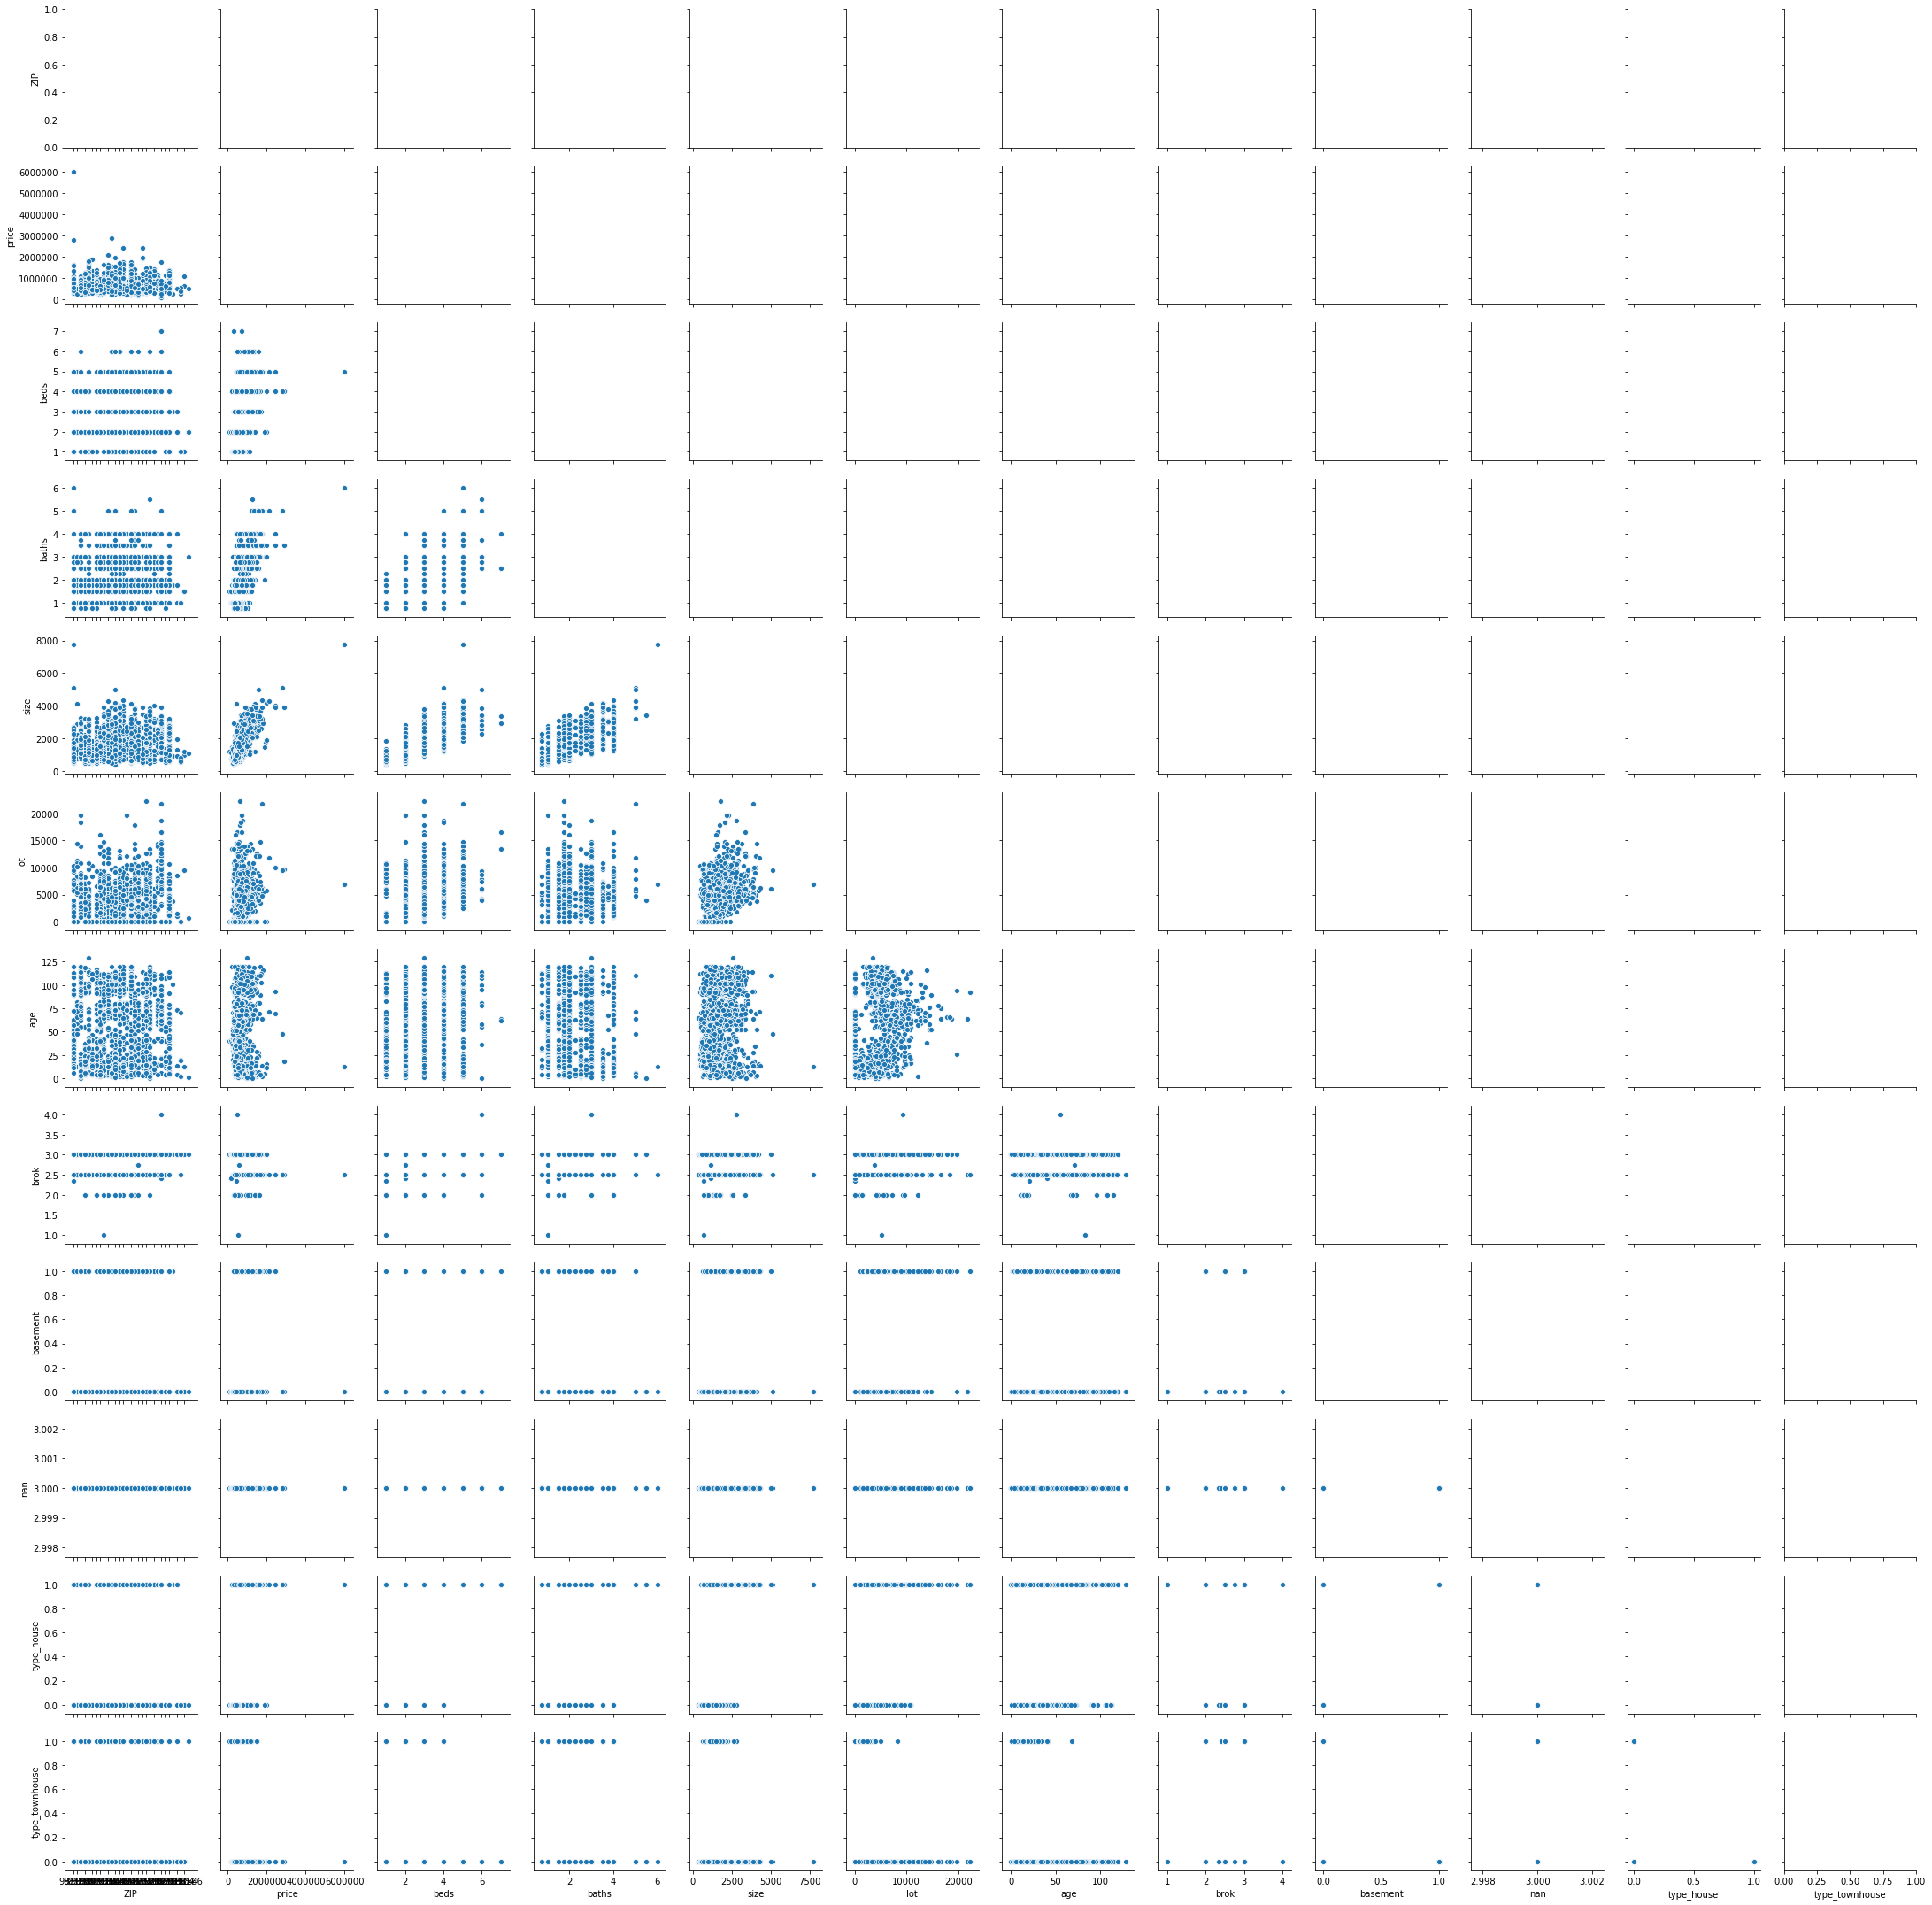

In [84]:
listing_pairplot = sbn.PairGrid(converted_data_simple, diag_sharey=False)
listing_pairplot.map_lower(sbn.scatterplot)


Nothing looks too concerning yet, though I'm annoyed that the sold date didn't graph. Next step is zooming in on zip and price to look for clusters I can create, then scaling features and repeating the paired plot.

In [190]:
type_dummies['ppsqft'] = type_dummies['price']/type_dummies['size']
max_ppsqft_by_ZIP = type_dummies.groupby('ZIP').agg({'ppsqft': 'max'}).sort_values(by = 'ppsqft', ascending = False)
mean_ppsqft_by_ZIP = type_dummies.groupby('ZIP').agg({'ppsqft': 'mean'}).sort_values(by = 'ppsqft', ascending = False)
both_ppsqft_by_ZIP = mean_ppsqft_by_ZIP.join(max_ppsqft_by_ZIP, lsuffix = 'mean', rsuffix = 'max')
both_ppsqft_by_ZIP

,ppsqftmean,ppsqftmax
ZIP,,
98101,802.512961,1016.081871
98121,786.081001,1279.132791
98164,649.284254,649.284254
98102,644.196878,1125.866051
98109,605.686659,816.942551
98122,601.945259,853.080569
98119,576.046380,772.715909
98107,538.947402,897.260274
98155,522.855296,604.617605


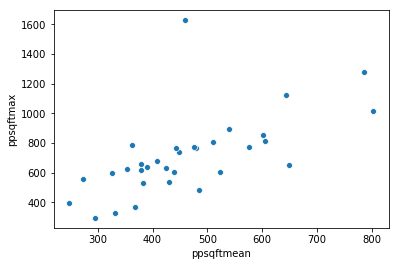

In [192]:
sbn.scatterplot(x = both_ppsqft_by_ZIP['ppsqftmean'], y = both_ppsqft_by_ZIP['ppsqftmax'])

In [198]:
mean_ppsqft_index = list(mean_ppsqft_by_ZIP.index)
mean_ppsqft_index

[98101,
 98121,
 98164,
 98102,
 98109,
 98122,
 98119,
 98107,
 98155,
 98112,
 98104,
 98103,
 98105,
 98115,
 98144,
 98116,
 98177,
 98199,
 98117,
 98136,
 98126,
 98133,
 98125,
 98108,
 98166,
 98118,
 98106,
 98134,
 98146,
 98188,
 98178,
 98168]

In [205]:
zip_sorted_listings = type_dummies
zip_sorted_listings['ZIP'] = zip_sorted_listings.to_string(columns = ['ZIP'])
zip_sorted_listings
#zip_sorted_listings['ZIP_cat'] = pd.Categorical(zip_sorted_listings['ZIP'], categories = mean_ppsqft_index, ordered = True)
#sbn.boxplot(zip_sorted_listings['ZIP_cat'], zip_sorted_listings['price'])

KeyboardInterrupt: 

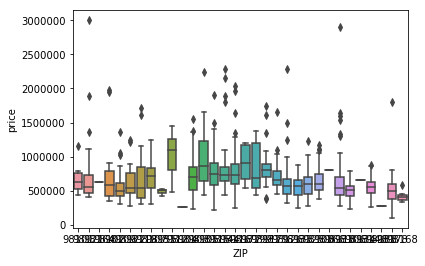

In [197]:
sbn.boxplot(type_dummies['ZIP'], type_dummies['price'], order = mean_ppsqft_index)

In [89]:
converted_data_simple.groupby('ZIP')['price'].count()


ZIP
98101     24
98102     55
98103    191
98104      4
98105     54
98106    113
98107    112
98108     93
98109     96
98112     15
98115    149
98116    129
98117     95
98118    136
98119     63
98121     78
98122     60
98125    123
98126    127
98133     86
98136     78
98144     74
98146     46
98155      3
98164      2
98166      1
98168     14
98177     20
98178     63
98188      1
98199     46
Name: price, dtype: int64

Quintiles should be around 400 sales (423 to be exact)
ZIP  	mean ppsqft	max ppsqft	count
98101	802.512961	1016.081871	24
98121	786.081001	1279.132791	78
98164	649.284254	649.284254	2
98102	644.196878	1125.866051	55
98109	605.686659	816.942551	96
98122	601.945259	853.080569	60
98119	576.046380	772.715909	63

98107	538.947402	897.260274	112
98155	522.855296	604.617605	3
98112	510.318873	804.054054	15
98104	485.185185	485.185185	4
98103	478.943852	768.175583	191
98105	475.292537	776.666667	54

98115	458.610470	1627.906977	149
98144	448.415199	742.574257	74
98116	442.142293	770.000000	129
98177	439.687735	605.042017	20
98199	430.294330	537.401575	46

98117	425.234565	631.666667	95
98136	408.930960	679.487179	78
98126	389.559360	639.344262	127
98133	382.497742	532.407407	86
98125	379.199581	656.250000	123

98108	378.526568	617.592593	93
98166	368.493782	368.493782	1
98118	361.895831	790.000000	136
98106	353.592584	627.430556	113
98134	331.658291	331.658291	1
98146	326.714216	595.505618	46
98188	295.591398	295.591398	1
98178	273.639970	554.794521	63
98168	247.465992	394.339623	14

In [98]:
zip_quintiles = {98101: 5, 98121: 5, 98164: 5, 98102: 5, 98109: 5, 98122: 5, 98119: 5, 
                 98107: 4, 98155: 4, 98112: 4, 98104: 4, 98103: 4, 98105: 4, 
                 98115: 3, 98144: 3, 98116: 3, 98177: 3, 98199: 3, 
                 98117: 2, 98136: 2, 98126: 2, 98133: 2, 98125: 2, 
                 98108: 1, 98166: 1, 98118: 1, 98106: 1, 98134: 1, 98146: 1, 98188: 1, 98178: 1, 98168: 1}
converted_data_simple['ZIP'] = converted_data_simple['ZIP'].map(zip_quintiles)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
#converted_data_simple['sold'] = converted_data['sale_age']
converted_data_simple = converted_data.iloc[:, :-2]
converted_data_simple

,ZIP,price,beds,baths,size,lot,age,sold,brok,type,basement
0,5.0,445000.0,2.0,1.00,911.0,0.51,43,0.780822,None,condo,0
1,1.0,580000.0,5.0,3.00,2084.0,6543.00,12,2.372603,None,house,0
2,1.0,780000.0,3.0,2.50,2487.0,5000.00,3,0.186301,None,house,0
3,5.0,455000.0,1.0,1.00,766.0,7200.00,22,1.610959,None,condo,0
4,5.0,1710000.0,3.0,4.00,2730.0,5000.00,103,0.147945,None,house,1
...,...,...,...,...,...,...,...,...,...,...,...
3098,2.0,549000.0,2.0,1.50,1530.0,6000.00,67,2.956164,None,house,0
3099,3.0,402000.0,2.0,1.00,868.0,0.00,35,0.556164,None,condo,0
3100,5.0,345000.0,1.0,1.00,717.0,0.00,18,3.893151,None,condo,0
3102,1.0,601250.0,5.0,2.75,2040.0,8906.00,33,2.441096,None,house,0


In [116]:
def ageConversion(datetime):
    return (dt.datetime.today() - datetime).days/365
ageConversion(dt.datetime(2020, 9, 1))

0.09863013698630137

In [117]:
converted_data_simple['sale_age'] = converted_data_simple['sold'].map(ageConversion)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [127]:
with open('converted_data_simple.txt', 'wb') as fp:
    pickle.dump(converted_data_simple, fp)